In [1]:
#NB need to use environment with python3.9 or above for ccf_streamlines to run
import nrrd
import numpy as np
import matplotlib.pyplot as plt
import ccf_streamlines.projection as ccfproj
import pathlib
import pandas as pd
import numpy as np
import os
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.colors import LogNorm
import copy
import cv2
import seaborn as sb
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable


In [2]:
reg_dir = pathlib.Path('/nemo/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/allenccf/allen_ccf_coord')
ROI_path = pathlib.Path('/nemo/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/rois')
ROI_table = pathlib.Path('/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/allenccf/ROI_vol.pkl')
allen_converted_path = pathlib.Path('/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/allenccf/allen_ccf_coord')
convert_to_flat_path = allen_converted_path.parents[1]
lcm_reg_dir = pathlib.PurePath('/nemo/lab/znamenskiyp/home/shared/code/MAPseq_processing/AC_MAPseq/Brain1_FIAA32.6a/LCM_registration')
reads_path = pathlib.Path("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA32.6a/Sequencing/Source_target_together")
RTtosample = pd.read_csv(allen_converted_path.parents[2]/ 'Sequencing/Processed_data/UpdatedApril/tube_to_RT.csv')
normalised_barcode_path= pathlib.Path('/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA32.6a/Sequencing/Source_target_together/barcode_matrix_normalised.pkl')
areas = pd.read_csv(lcm_reg_dir/'3d_areas.csv')

In [3]:
np.seterr(divide = 'ignore') 

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:
bf_boundary_finder = ccfproj.BoundaryFinder(
    projected_atlas_file=convert_to_flat_path/"flatmap_butterfly.nrrd",
    labels_file=convert_to_flat_path/"labelDescription_ITKSNAPColor.txt",
)

# We get the left hemisphere region boundaries with the default arguments
bf_left_boundaries = bf_boundary_finder.region_boundaries()

# And we can get the right hemisphere boundaries that match up with
# our projection if we specify the same configuration
bf_right_boundaries = bf_boundary_finder.region_boundaries(
    # we want the right hemisphere boundaries, but located in the right place
    # to plot both hemispheres at the same time
    hemisphere='right_for_both',

    # we also want the hemispheres to be adjacent
    view_space_for_other_hemisphere='flatmap_butterfly',
)

In [5]:
proj_top = ccfproj.Isocortex2dProjector(
    # Specify our view lookup file
    convert_to_flat_path/"flatmap_butterfly.h5",

    # Specify our streamline file
    convert_to_flat_path/"surface_paths_10_v3.h5",

    # Specify that we want to project both hemispheres
    hemisphere="both",

    # The top view contains space for the right hemisphere, but is empty.
    # Therefore, we tell the projector to put both hemispheres side-by-side
    view_space_for_other_hemisphere='flatmap_butterfly',
)

loading path information


100%|██████████| 1016/1016 [00:05<00:00, 170.72it/s]


For generating initial np array of allen coordinates labelled with unique tube numbers (don't need to repeat, as can load from saved file)

In [6]:
#download av template to get shape
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
mcc = MouseConnectivityCache(resolution=10)
avg_temp, meta = mcc.get_template_volume()


In [ ]:
#re-get registration info on each ROI
#iterate through individual slices, take average difference in in coordinates in z (which is x axes in allen ccf) for last slice (slice s001 for brain 1), take average of previous slices
add_z = pd.DataFrame(columns=['slice', 'amountz'], dtype=int)
#need to change for mega thick last bit of cortex section, so extend ROI through 3slices
for file in os.listdir(allen_converted_path):
    if file.startswith('allen_ccf_converted_'):
        slice_name = file[20:24]
        slicenum = int(file[21:24])
        if slice_name != 's001' and slice_name != 's012' and slice_name != 's048' and slice_name != 's053':
            slice_before= slicenum-1
            if slice_before >9:
                slicebefore_name = f's0{slice_before}' 
            if slice_before<10:
                slicebefore_name = f's00{slice_before}' 
            [x1a, y1a, z1a, one1] = np.load(allen_converted_path/file)
            [x2a, y2a, z2a, one2] = np.load(allen_converted_path/f'allen_ccf_converted_{slicebefore_name}.npy')
            dif = np.average(x2a.flatten()-x1a.flatten())
            add_z= pd.concat([add_z, pd.DataFrame({'slice': slice_name, 'amountz': dif}, index=[0])], ignore_index=True)

#for slices where the one's before are missing, extend them by the mean of slice z extensions for the others
s001_add =add_z['amountz'].mean()
add_z= pd.concat([add_z, pd.DataFrame({'slice': 's001', 'amountz': s001_add}, index=[0])],ignore_index=True)
s012_add =add_z['amountz'].mean()
add_z= pd.concat([add_z, pd.DataFrame({'slice': 's012', 'amountz': s012_add}, index=[0])],ignore_index=True)
s048_add =add_z['amountz'].mean()
add_z= pd.concat([add_z, pd.DataFrame({'slice': 's048', 'amountz': s048_add}, index=[0])],ignore_index=True)
s053_add =add_z['amountz'].mean()
add_z= pd.concat([add_z, pd.DataFrame({'slice': 's053', 'amountz': s053_add}, index=[0])],ignore_index=True)


In [6]:
#we only want to look at the samples that are cortical
cortical_areas =[38, 57, 58, 71, 6, 7, 10, 11, 12, 15, 16, 17, 18, 21, 22, 23, 24, 26, 27, 28, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 59, 60, 61, 62, 63, 64, 65, 70, 82, 83, 84, 85, 86]
cortical_samples_table =RTtosample[RTtosample['RT primer'].isin (cortical_areas)]

In [ ]:
#get e.g. of ROI
empty_frame = np.zeros((avg_temp.shape))
for ROI_to_look in os.listdir(ROI_path):
#region = ROI_path/'s015_TUBE6.png'
    region = ROI_path/ROI_to_look
    if ROI_to_look.startswith('s0'):
        slicename = region.stem[0:4]
        tube = region.stem[5:len(region.stem)].split('TUBE', 1)[1]
        if int(tube) in cortical_samples_table['Tube'].to_list():
            [xa, ya, za, one] = np.load(allen_converted_path/f'allen_ccf_converted_{slicename}.npy')
            roi = plt.imread(ROI_path/f'{region}')
            allencoord_roiya = roi*ya
            allencoord_roiza = roi*za
            allencoord_roixa= roi*xa
            z_to_add = add_z.loc[add_z['slice'] == slicename, 'amountz'].iloc[0]

            #convert the x, y, z coordinates to pixel
            pixcoord = []
            for i, axis in enumerate([allencoord_roixa, allencoord_roiya, allencoord_roiza]):
                pixel = np.array(np.round(axis/10), dtype=int)
                pixel[pixel <0] = 0
                pixel[pixel >= empty_frame.shape[i]] = 0
                pixcoord.append(pixel)
            new_coord = np.zeros(pixcoord[0].shape)
            z_add=0
            for stack in range(int(np.round(-z_to_add/10))):
                for i in range(pixcoord[0].shape[0]):
                    for j in range(pixcoord[0].shape[1]):
                        if pixcoord[0][i, j] != 0:
                            new_coord[i,j] = (pixcoord[0][i, j])+z_add
                z_add = z_add+1
                for k in range(pixcoord[0].shape[0]):
                    for l in range(pixcoord[0].shape[1]):
                        x = new_coord[k, l]
                        y = pixcoord[1][k, l]
                        z = pixcoord[2][k, l]
                        if x != 0 and y != 0 and z != 0:
                            empty_frame[int(x), int(y), int(z)] = int(tube)

In [7]:

tab20 = cm.get_cmap('gist_ncar', 250)
tab20_cmap = tab20(np.linspace(0, 1, 20))
new_colors =tab20(np.linspace(0, 1, max(cortical_samples_table.Tube.to_list())))

black = np.array([1/256, 1/256, 1/256, 1])

for i, row in enumerate(new_colors):
    if i == 0:
        new_colors[i, :] = black
    else:
        idx = np.random.randint(20)
        new_colors[i, :] = tab20_cmap[idx]
newcmp = ListedColormap(new_colors)


In [11]:
bf_boundary_finder = ccfproj.BoundaryFinder(
    projected_atlas_file=convert_to_flat_path/"flatmap_butterfly.nrrd",
    labels_file=convert_to_flat_path/"labelDescription_ITKSNAPColor.txt",
)

# We get the left hemisphere region boundaries with the default arguments
bf_left_boundaries = bf_boundary_finder.region_boundaries()

# And we can get the right hemisphere boundaries that match up with
# our projection if we specify the same configuration
bf_right_boundaries = bf_boundary_finder.region_boundaries(
    # we want the right hemisphere boundaries, but located in the right place
    # to plot both hemispheres at the same time
    hemisphere='right_for_both',

    # we also want the hemispheres to be adjacent
    view_space_for_other_hemisphere='flatmap_butterfly',
)

In [10]:
proj_top = ccfproj.Isocortex2dProjector(
    # Specify our view lookup file
    convert_to_flat_path/"flatmap_butterfly.h5",

    # Specify our streamline file
    convert_to_flat_path/"surface_paths_10_v3.h5",

    # Specify that we want to project both hemispheres
    hemisphere="both",

    # The top view contains space for the right hemisphere, but is empty.
    # Therefore, we tell the projector to put both hemispheres side-by-side
    view_space_for_other_hemisphere='flatmap_butterfly',
)

loading path information


100%|██████████| 1016/1016 [00:06<00:00, 166.62it/s]


In [ ]:
top_projection_max = proj_top.project_volume(empty_frame)

plt.imshow(
    top_projection_max.T, # transpose so that the rostral/caudal direction is up/down
    interpolation='none',
    cmap=newcmp,
)
cbar = plt.colorbar()
for k, boundary_coords in bf_left_boundaries.items():
    plt.plot(*boundary_coords.T, c="white", lw=0.5)
for k, boundary_coords in bf_right_boundaries.items():
    plt.plot(*boundary_coords.T, c="white", lw=0.5)

In [ ]:
np.save(convert_to_flat_path/'ROI_cortical_3D', empty_frame)

Now look at individual barcodes on map

In [8]:
ROI_flatmap = np.load(convert_to_flat_path/'ROI_cortical_3D.npy')
normalised_barcode_path =pd.read_pickle(normalised_barcode_path)

In [9]:
new_columns= {}
for i, r in RTtosample.iterrows():
    new_columns[r['RT primer']]= r['Tube'] #create a dictionary to rename columns in the barcode matrix with tube names rather than RT sample names
normalised_barcode_path = normalised_barcode_path.rename(columns=new_columns)

In [10]:
#remove tubes in ROI flatmap that aren't in normalised barcode path
tubes = np.arange(1, 93, 1)
tubes_not_in = [i for i in tubes if i not in normalised_barcode_path.columns.to_list()]

In [11]:
for x in tubes_not_in:
    ROI_flatmap[ROI_flatmap == x] = 0

In [12]:
ROI_projection_max = proj_top.project_volume(ROI_flatmap)


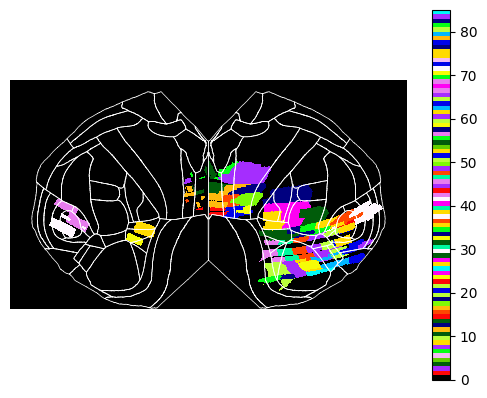

In [ ]:
top_projection_max = proj_top.project_volume(ROI_flatmap)

plt.imshow(
    top_projection_max.T, # transpose so that the rostral/caudal direction is up/down
    interpolation='none',
    cmap=newcmp,
)
plt.axis('off')
cbar = plt.colorbar()
for k, boundary_coords in bf_left_boundaries.items():
    plt.plot(*boundary_coords.T, c="white", lw=0.5)
for k, boundary_coords in bf_right_boundaries.items():
    plt.plot(*boundary_coords.T, c="white", lw=0.5)

In [13]:
barcode_matrix = np.zeros((len(normalised_barcode_path), max(normalised_barcode_path.columns.to_list())+1))
#need to (a) take only cortical samples to look at, (b) make non-cortical samples visualisable on separate colour bar
#(c) look at counts only
#(d) show outlines of roi's so you know which one's are being avoided


In [18]:
for column in normalised_barcode_path:
    barcode_matrix[:, column] = normalised_barcode_path[column].to_numpy()

In [19]:
total_counts = np.sum(barcode_matrix, axis=0)

In [20]:
#now set zero values to -1
total_counts[0] = -1

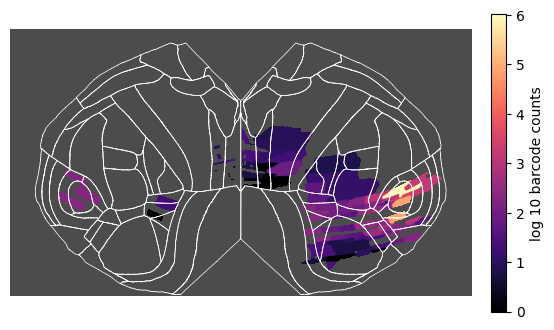

In [21]:
new_mat = np.log10(1 + total_counts[ROI_projection_max.astype(int)]).T

cmap = plt.cm.get_cmap("magma").copy()

cmap.set_bad(color=[0.3 , 0.3 , 0.3 , 1 ])  # Set NaN values as grey

plt.imshow(new_mat, cmap=cmap)
plt.axis('off')
plt.colorbar(label='log 10 barcode counts', fraction=0.03, pad=0.04)
for k, boundary_coords in bf_left_boundaries.items():
    plt.plot(*boundary_coords.T, c="white", lw=0.5)
for k, boundary_coords in bf_right_boundaries.items():
    plt.plot(*boundary_coords.T, c="white", lw=0.5)


In [24]:
#also calculate sum of projection density
density_barcodes = pd.DataFrame()
for col in normalised_barcode_path.columns:
    density_barcodes[col] = normalised_barcode_path[col]/(areas_to_look.loc[col].sum())

In [55]:
barcode_density_matrix.shape

(2335, 94)

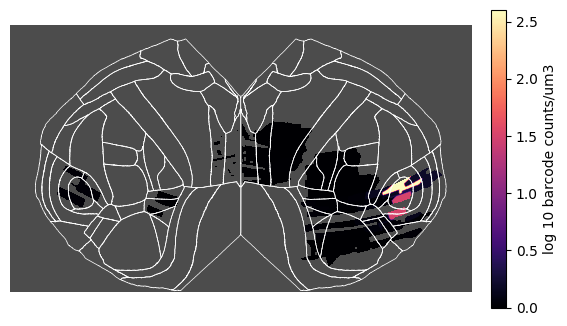

In [25]:
barcode_density_matrix = np.zeros((len(density_barcodes), max(density_barcodes.columns.to_list())+1))
for column in density_barcodes:
    barcode_density_matrix[:, column] = density_barcodes[column].to_numpy()
average_density = np.average(barcode_density_matrix, axis=0)
average_density[0] = -1
new_mat = np.log10(1 + average_density[ROI_projection_max.astype(int)]).T

cmap = plt.cm.get_cmap("magma").copy()

cmap.set_bad(color=[0.3 , 0.3 , 0.3 , 1 ])  # Set NaN values as grey

plt.imshow(new_mat, cmap=cmap)
plt.axis('off')
plt.colorbar(label='log 10 barcode counts/um3', fraction=0.03, pad=0.04)
for k, boundary_coords in bf_left_boundaries.items():
    plt.plot(*boundary_coords.T, c="white", lw=0.5)
for k, boundary_coords in bf_right_boundaries.items():
    plt.plot(*boundary_coords.T, c="white", lw=0.5)


In [ ]:
#if barcode_matrix columns aren't included final list of sample barcodes after QC, set them to zero
# for column in range(max(normalised_barcode_path.columns.to_list())+1):
#     if column not in normalised_barcode_path.columns.to_list():
#         barcode_matrix[:, column] = -1 

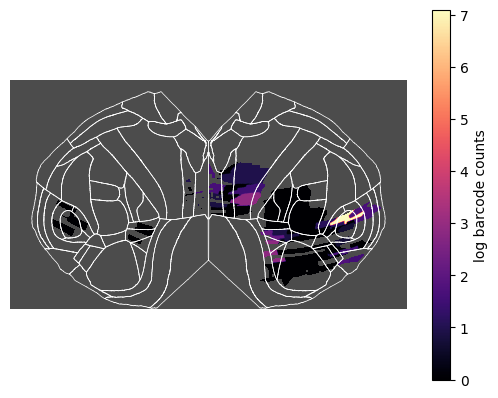

In [26]:
barcode_matrix = np.zeros((len(normalised_barcode_path), max(normalised_barcode_path.columns.to_list())+1))

for column in normalised_barcode_path:
    barcode_matrix[:, column] = normalised_barcode_path[column].to_numpy()

#now set zero values to -1
barcode_matrix[:, 0] = -1

barcode_index = 2
new_mat = np.log(1 + barcode_matrix[barcode_index, ROI_projection_max.astype(int)]).T

cmap = plt.cm.get_cmap("magma").copy()

cmap.set_bad(color=[0.3 , 0.3 , 0.3 , 1 ])  # Set NaN values as grey

plt.imshow(new_mat, cmap=cmap)
plt.axis('off')
plt.colorbar(label='log barcode counts')
for k, boundary_coords in bf_left_boundaries.items():
    plt.plot(*boundary_coords.T, c="white", lw=0.5)
for k, boundary_coords in bf_right_boundaries.items():
    plt.plot(*boundary_coords.T, c="white", lw=0.5)


In [ ]:
# create subplots of 100 random barcodes

plt.figure(figsize=(50, 100))
np.seterr(divide="ignore")
plt.rcParams["figure.constrained_layout.use"] = True
# loop through the length of tickers and keep track of ind

Now can add subcortical projecitons into image

In [27]:
sub_cortical= {}
sub_cortical['IC'] = [86, 89, 90]
sub_cortical['SC'] = [68, 78, 92, 87, 69, 79, 93]
#sub_cortical['CLA'] = [20, 25, 9, 14]
sub_cortical['R_STR'] = [8, 13, 19]
sub_cortical['C_STR'] = [29]
sub_cortical['PONS'] = [72, 80, 88]



In [28]:
#only look at subcortical regions that have passed qc
sub_cortical_updated = {}
for i in sub_cortical:
    sub_cortical_updated[i] = []
    for val in sub_cortical[i]:
        if val in normalised_barcode_path.columns.to_list():
            sub_cortical_updated[i].append(val)
            
            

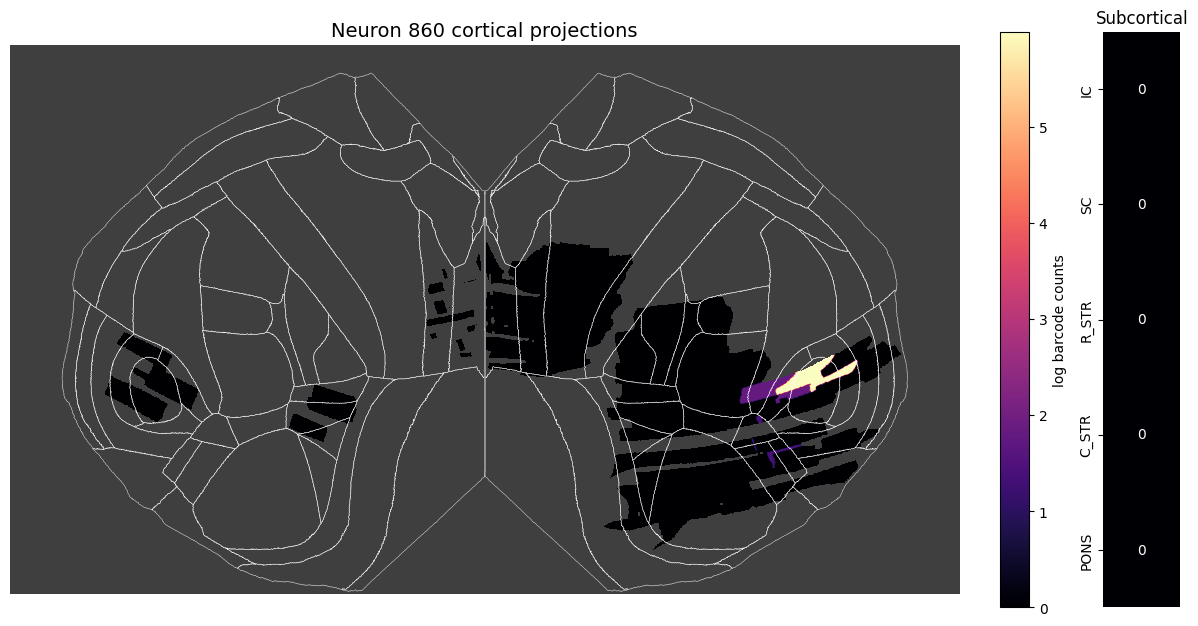

In [34]:
# Create the main figure and gridspec
for iteration in range(1):
    fig = plt.figure(figsize=(12, 300))
    gs = fig.add_gridspec(50, 2, width_ratios=[2, 0.15])
    cmap = plt.cm.get_cmap("magma").copy()
    #new_colours = cmap(np.linspace(0, 1, 30))
    #grey = ([0.3, 0.3, 0.3, 1])
    #new_colours[0, :] = grey
    #new_cmap = ListedColormap(new_colours)
    cmap.set_bad(color=[0.25, 0.25, 0.25, 1])
    # Iterate over barcode_index values
    for i in range(1):
        # add a new subplot iteratively
        barcode_index = np.random.randint(len(barcode_matrix))
        # Subplot - Main plot
        ax1 = fig.add_subplot(gs[i, 0])
        new_mat = np.log(1 + barcode_matrix[barcode_index, ROI_projection_max.astype(int)]).T
        new_fig = ax1.imshow(new_mat, cmap=cmap)
        ax1.axis('off')
        cbar = fig.colorbar(new_fig, ax=ax1, fraction=0.03, pad=0.04)
        cbar.set_label('log barcode counts')

        ax1.set_title(f'Neuron {barcode_index} cortical projections', fontdict={'fontsize': 14})
        for k, boundary_coords in bf_left_boundaries.items():
            ax1.plot(*boundary_coords.T, c="white", lw=0.3)
        for k, boundary_coords in bf_right_boundaries.items():
            ax1.plot(*boundary_coords.T, c="white", lw=0.3)

        # Subplot - Seaborn heatmap
        sub_cort_heat = pd.DataFrame(columns=sub_cortical.keys(), dtype="float")
        for col in sub_cort_heat.columns:
                sub_cort_heat.loc[0, col] = np.log(barcode_matrix[barcode_index,sub_cortical_updated[col]].sum()+1)
        ax2 = fig.add_subplot(gs[i, 1])
        sb.heatmap(sub_cort_heat.T, annot=True, cmap=cmap, cbar=False, cbar_ax=ax2, vmax=new_mat.max())
        ax2.set_title('Subcortical')
        ax2.set(xticklabels=[])
        #ax2.set_yticklabels(labels=sub_cortical.keys(), rotation=0)
        ax2.tick_params(left=True, bottom=False)
        
    plt.tight_layout()
    plt.show()
    
    #plt.savefig(convert_to_flat_path/f'example_projections/random_{iteration}.pdf')

Now lets have a look at only those with projections to visual areas

In [35]:
areas_vis = areas.set_index('sample')
vis = areas_vis.filter(like="VIS").columns
areas_vis = areas_vis[vis]
areas_vis =areas_vis.drop(['VISC', 'Contra-VISa', 'Contra-VISam', 'Contra-VISC'], axis=1)
areas_vis =areas_vis.loc[~(areas_vis==0).all(axis=1)]
visual_areas =areas_vis.index.to_list()

In [36]:
#remove the samples that are not in final qc and turn to int
visual_areas_list = []
for val in visual_areas:
    if val in normalised_barcode_path.columns.to_list():
        visual_areas_list.append(int(val))
non_zero_rows = np.any(barcode_matrix[:, visual_areas_list] != 0, axis=1)
filtered_vis_only = barcode_matrix[non_zero_rows]

In [57]:
len(filtered_vis_only)

493

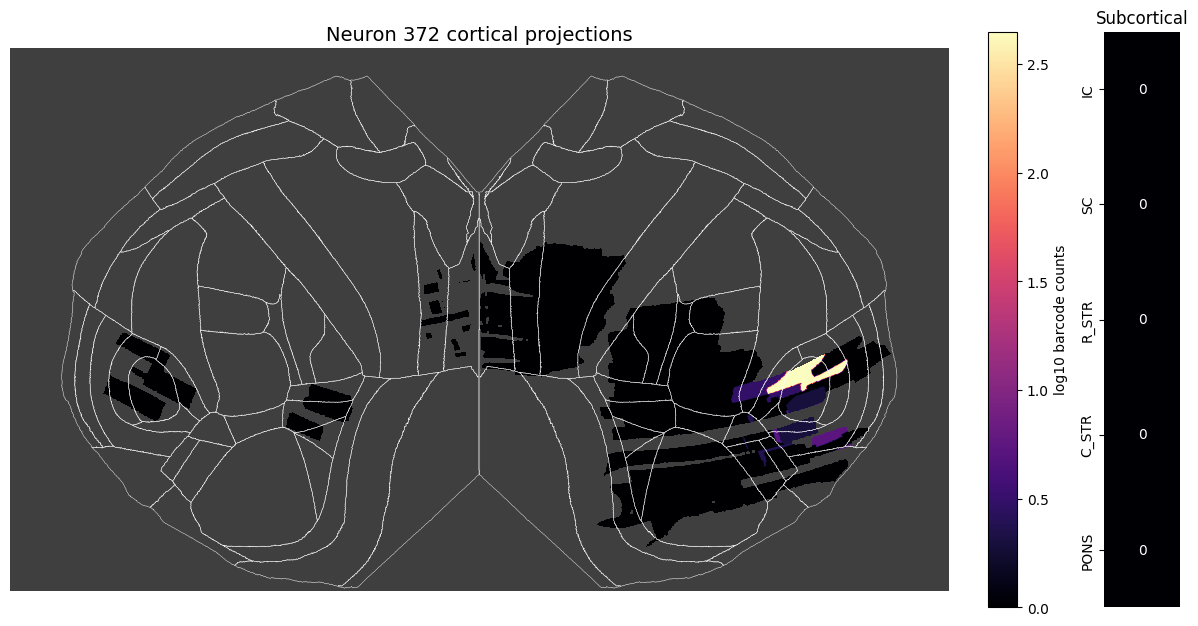

In [62]:
# Create the main figure and gridspec
for iteration in range(1):
    fig = plt.figure(figsize=(12, 300))
    gs = fig.add_gridspec(50, 2, width_ratios=[2, 0.15])
    cmap = plt.cm.get_cmap("magma").copy()
    #new_colours = cmap(np.linspace(0, 1, 30))
    #grey = ([0.3, 0.3, 0.3, 1])
    #new_colours[0, :] = grey
    #new_cmap = ListedColormap(new_colours)
    cmap.set_bad(color=[0.25, 0.25, 0.25, 1])
    # Iterate over barcode_index values
    for i in range(1):
        # add a new subplot iteratively
        barcode_index = np.random.randint(len(filtered_vis_only))
        # Subplot - Main plot
        ax1 = fig.add_subplot(gs[i, 0])
        new_mat = np.log10(1 + filtered_vis_only[barcode_index, ROI_projection_max.astype(int)]).T
        new_fig = ax1.imshow(new_mat, cmap=cmap)
        ax1.axis('off')
        cbar = fig.colorbar(new_fig, ax=ax1, fraction=0.03, pad=0.04)
        cbar.set_label('log10 barcode counts')

        ax1.set_title(f'Neuron {barcode_index} cortical projections', fontdict={'fontsize': 14})
        for k, boundary_coords in bf_left_boundaries.items():
            ax1.plot(*boundary_coords.T, c="white", lw=0.3)
        for k, boundary_coords in bf_right_boundaries.items():
            ax1.plot(*boundary_coords.T, c="white", lw=0.3)

        # Subplot - Seaborn heatmap
        sub_cort_heat = pd.DataFrame(columns=sub_cortical.keys(), dtype="float")
        for col in sub_cort_heat.columns:
                sub_cort_heat.loc[0, col] = np.log10(filtered_vis_only[barcode_index,sub_cortical_updated[col]].sum()+1)
        ax2 = fig.add_subplot(gs[i, 1])
        sb.heatmap(sub_cort_heat.T, annot=True, cmap=cmap, cbar=False, cbar_ax=ax2, vmax=new_mat.max())
        ax2.set_title('Subcortical')
        ax2.set(xticklabels=[])
        #ax2.set_yticklabels(labels=sub_cortical.keys(), rotation=0)
        ax2.tick_params(left=True, bottom=False)
        
    plt.tight_layout()
    plt.show()
    
    #plt.savefig(convert_to_flat_path/f'example_projections/random_{iteration}.pdf')

What does the average projection look like with neurons from different HVAs?

In [23]:
all_areas_fractions = pd.DataFrame(index=normalised_barcode_path.columns)
all_areas_fractions['name'] = ''
areas_to_look = areas.set_index('sample')
#drop tube 5, which has no registration information
areas_to_look = areas_to_look.drop(5, axis =0)
for i, row in areas_to_look.iterrows():
    row /= row.sum(0)
    
    if row[row.idxmax()]>0.9999:
        name= str(row.idxmax()) + ' ' + str(row[row.idxmax()].round(2))
    else:
        second_highest_row = row.drop(row.idxmax())
        name= str(row.idxmax()) + ' ' + str(row[row.idxmax()].round(2)) + ' ' + str(second_highest_row.idxmax()) + ' ' + str(row[second_highest_row.idxmax()].round(2))
    all_areas_fractions.loc[i] = name
    

In [21]:
non_zero_rows = np.any(barcode_matrix[:, [49, 31]] != 0, axis=1)
filtered_vis_only = barcode_matrix[non_zero_rows]

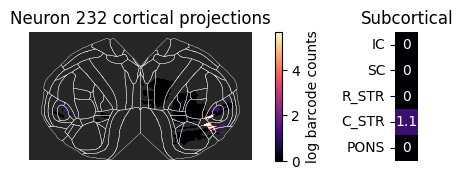

In [23]:
# Create the main figure and gridspec
fig = plt.figure(figsize=(7, 100))
gs = fig.add_gridspec(50, 2, width_ratios=[2, 0.1])
cmap = plt.cm.get_cmap("magma").copy()
#new_colours = cmap(np.linspace(0, 1, 30))
#grey = ([0.3, 0.3, 0.3, 1])
#new_colours[0, :] = grey
#new_cmap = ListedColormap(new_colours)
cmap.set_bad(color=[0.15, 0.15, 0.15, 1])
# Iterate over barcode_index values
for i in range(1):
    # add a new subplot iteratively
    barcode_index = np.random.randint(len(filtered_vis_only))
    # Subplot - Main plot
    ax1 = fig.add_subplot(gs[i, 0])
    new_mat = np.log(1 + filtered_vis_only[barcode_index, ROI_projection_max.astype(int)]).T
    new_fig = ax1.imshow(new_mat, cmap=cmap)
    ax1.axis('off')
    cbar = fig.colorbar(new_fig, ax=ax1)
    cbar.set_label('log barcode counts')

    ax1.set_title(f'Neuron {barcode_index} cortical projections')
    for k, boundary_coords in bf_left_boundaries.items():
        ax1.plot(*boundary_coords.T, c="white", lw=0.25)
    for k, boundary_coords in bf_right_boundaries.items():
        ax1.plot(*boundary_coords.T, c="white", lw=0.25)

    # Subplot - Seaborn heatmap
    sub_cort_heat = pd.DataFrame(columns=sub_cortical.keys(), dtype="float")
    for col in sub_cort_heat.columns:
            sub_cort_heat.loc[0, col] = np.log(filtered_vis_only[barcode_index,sub_cortical_updated[col]].sum()+1)
    ax2 = fig.add_subplot(gs[i, 1])
    sb.heatmap(sub_cort_heat.T, annot=True, cmap=cmap, cbar=False, cbar_ax=ax2, vmax=new_mat.max())
    ax2.set_title('Subcortical')
    ax2.set(xticklabels=[])
    #ax2.set_yticklabels(labels=sub_cortical.keys(), rotation=0)
    ax2.tick_params(left=True, bottom=False)
    

# Adjust figure layout for better spacing
#fig.tight_layout()

# Show the plot
plt.show()

Plot e.g's of over-represented motifs

In [55]:
#make average with thresholding# require a threshold for col of interest projection strength

column_x = 48  # Column to filter on
threshold = 0.05

# Normalize each row to its maximum value
normalized_matrix = barcode_matrix / np.max(barcode_matrix, axis=1, keepdims=True)

# Filter rows based on values greater than 0 in column_x
filtered_matrix = normalized_matrix[normalized_matrix[:, column_x] >= threshold]


normalized_matrix_mean = np.mean(filtered_matrix, axis=0)
normalized_matrix_mean[0] = -1



In [56]:
# require a threshold for col of interest projection strength

column_x = 47  # Column to filter on
threshold = 0.05

# Normalize each row to its maximum value
normalized_matrix = barcode_matrix / np.max(barcode_matrix, axis=1, keepdims=True)

# Filter rows based on values greater than 0 in column_x
filtered_matrix = normalized_matrix[normalized_matrix[:, column_x] >= threshold]


normalized_matrix_mean = np.mean(filtered_matrix, axis=0)
normalized_matrix_mean[0] = -1



In [67]:
non_zero_rows = np.all(barcode_matrix[:, [31, 49]] != 0, axis=1)
filtered_vis_only = barcode_matrix[non_zero_rows]

In [41]:
len(filtered_vis_only)

26

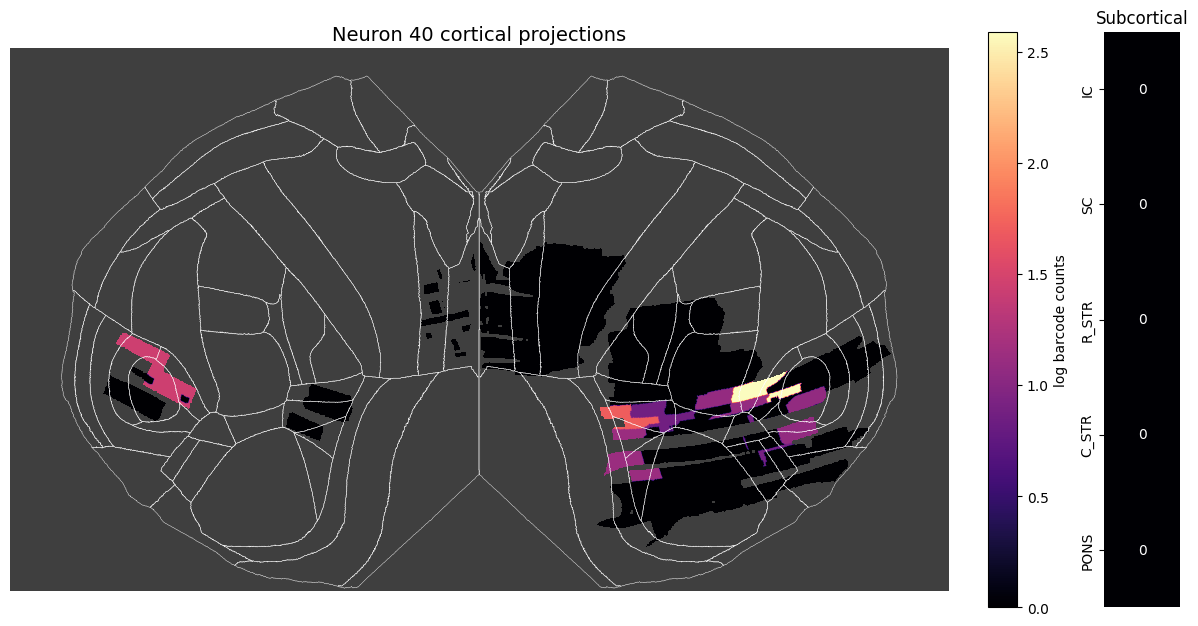

In [70]:
# Create the main figure and gridspec

fig = plt.figure(figsize=(12, 300))
gs = fig.add_gridspec(50, 2, width_ratios=[2, 0.15])
cmap = plt.cm.get_cmap("magma").copy()
#new_colours = cmap(np.linspace(0, 1, 30))
#grey = ([0.3, 0.3, 0.3, 1])
#new_colours[0, :] = grey
#new_cmap = ListedColormap(new_colours)
cmap.set_bad(color=[0.25, 0.25, 0.25, 1])
# Iterate over barcode_index values
for i in range(1):
    # add a new subplot iteratively
    barcode_index = np.random.randint(len(filtered_vis_only))
    # Subplot - Main plot
    ax1 = fig.add_subplot(gs[i, 0])
    new_mat = np.log(1 + filtered_vis_only[barcode_index, ROI_projection_max.astype(int)]).T
    new_fig = ax1.imshow(new_mat, cmap=cmap)
    ax1.axis('off')
    cbar = fig.colorbar(new_fig, ax=ax1, fraction=0.03, pad=0.04)
    cbar.set_label('log barcode counts')

    ax1.set_title(f'Neuron {barcode_index} cortical projections', fontdict={'fontsize': 14})
    for k, boundary_coords in bf_left_boundaries.items():
        ax1.plot(*boundary_coords.T, c="white", lw=0.3)
    for k, boundary_coords in bf_right_boundaries.items():
        ax1.plot(*boundary_coords.T, c="white", lw=0.3)

    # Subplot - Seaborn heatmap
    sub_cort_heat = pd.DataFrame(columns=sub_cortical.keys(), dtype="float")
    for col in sub_cort_heat.columns:
            sub_cort_heat.loc[0, col] = np.log(filtered_vis_only[barcode_index,sub_cortical_updated[col]].sum()+1)
    ax2 = fig.add_subplot(gs[i, 1])
    sb.heatmap(sub_cort_heat.T, annot=True, cmap=cmap, cbar=False, cbar_ax=ax2, vmax=new_mat.max())
    ax2.set_title('Subcortical')
    ax2.set(xticklabels=[])
    #ax2.set_yticklabels(labels=sub_cortical.keys(), rotation=0)
    ax2.tick_params(left=True, bottom=False)
    
plt.tight_layout()
plt.show()

#plt.savefig(convert_to_flat_path/f'example_projections/random_{iteration}.pdf')

Take average projection for samples that are non zero in pm/al projecting

In [41]:

# column_x = 84 # Column to filter on

# # Filter rows based on values greater than 0 in column_x
# filtered_matrix = barcode_matrix[barcode_matrix[:, column_x] > 0]

# # Normalize each row to its maximum value
# normalized_matrix = filtered_matrix / np.max(filtered_matrix, axis=1, keepdims=True)

# normalized_matrix_mean = np.mean(normalized_matrix, axis=0)
# normalized_matrix_mean[0] = -1

In [29]:
bl = np.mean(barcode_matrix, axis=0)
bl.shape

(94,)

In [61]:
#look at only the smaples
columns = [47, 48]
new_tab = np.zeros(len(barcode_matrix))
for i in columns:
    new_tab[i] = np.random.randint(10)

new_tab[0] = np.nan
tab20 = cm.get_cmap('tab10', 10)
tab20_cmap = tab20(np.linspace(0, 1, 10))
#new_colors =tab20(np.linspace(0, 1, 20))

black = np.array([1/256, 1/256, 1/256, 1])


tab20_cmap[0, :] = black
    
newcmp = ListedColormap(tab20_cmap)


In [49]:
tab20_cmap

array([[0.00390625, 0.00390625, 0.00390625, 1.        ],
       [0.        , 0.36400458, 0.04230203, 1.        ],
       [0.        , 0.0100496 , 0.91049589, 1.        ],
       [0.        , 0.71633784, 1.        , 1.        ],
       [0.        , 0.96974166, 0.9676433 , 1.        ],
       [0.        , 0.9804    , 0.62535578, 1.        ],
       [0.02199023, 0.99818721, 0.0870836 , 1.        ],
       [0.38005407, 0.81096029, 0.        , 1.        ],
       [0.49670905, 0.98106005, 0.02384517, 1.        ],
       [0.72965039, 1.        , 0.23179261, 1.        ],
       [0.96725289, 0.98889074, 0.02865996, 1.        ],
       [1.        , 0.86012797, 0.        , 1.        ],
       [1.        , 0.7313652 , 0.05395495, 1.        ],
       [1.        , 0.27747453, 0.00322399, 1.        ],
       [1.        , 0.02921619, 0.0293705 , 1.        ],
       [1.        , 0.        , 0.95543542, 1.        ],
       [0.64747149, 0.17691755, 0.99967171, 1.        ],
       [0.90916972, 0.48570095,

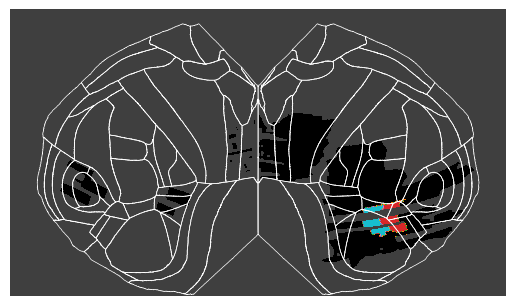

In [62]:

new_mat = new_tab[ROI_projection_max.astype(int)].T

#cmap = plt.cm.get_cmap("magma").copy()
#new_colours = cmap(np.linspace(0, 1, 30))
#grey = ([0.3, 0.3, 0.3, 1])
#new_colours[0, :] = grey
#new_cmap = ListedColormap(new_colours)
newcmp.set_bad(color=[0.25, 0.25, 0.25, 1])

plt.imshow(new_mat, cmap=newcmp)
plt.axis('off')
#plt.colorbar(label='log fraction barcode counts', fraction=0.03, pad=0.04)
for k, boundary_coords in bf_left_boundaries.items():
    plt.plot(*boundary_coords.T, c="white", lw=0.5)
for k, boundary_coords in bf_right_boundaries.items():
    plt.plot(*boundary_coords.T, c="white", lw=0.5)

In [57]:
# require a threshold for col of interest projection strength
#first column
column_x = 47 # Column to filter on
threshold = 0.001

# Normalize each row to its maximum value
normalized_matrix = barcode_matrix / np.max(barcode_matrix, axis=1, keepdims=True)

# Filter rows based on values greater than 0 in column_x
filtered_matrix = normalized_matrix[normalized_matrix[:, column_x] >= threshold]






In [58]:
column_2 = 48 # Column to filter on
threshold_2 = 0.001
# Filter rows based on values greater than 0 in column_x
filtered_matrix = filtered_matrix[filtered_matrix[:, column_2] >= threshold_2]

In [59]:

normalized_matrix_mean = np.mean(filtered_matrix, axis=0)
normalized_matrix_mean[0] = -1

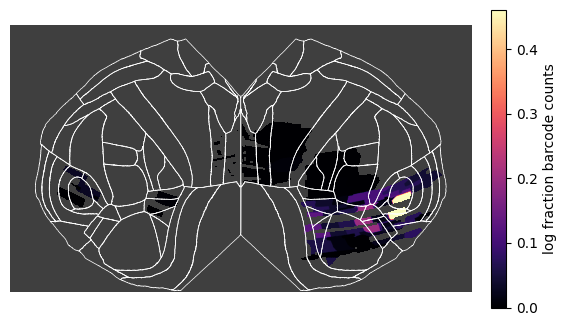

In [60]:

new_mat = np.log(1 + normalized_matrix_mean[ROI_projection_max.astype(int)]).T

cmap = plt.cm.get_cmap("magma").copy()
#new_colours = cmap(np.linspace(0, 1, 30))
#grey = ([0.3, 0.3, 0.3, 1])
#new_colours[0, :] = grey
#new_cmap = ListedColormap(new_colours)
cmap.set_bad(color=[0.25, 0.25, 0.25, 1])

plt.imshow(new_mat, cmap=cmap)
plt.axis('off')
plt.colorbar(label='log fraction barcode counts', fraction=0.03, pad=0.04)
for k, boundary_coords in bf_left_boundaries.items():
    plt.plot(*boundary_coords.T, c="white", lw=0.5)
for k, boundary_coords in bf_right_boundaries.items():
    plt.plot(*boundary_coords.T, c="white", lw=0.5)

In [37]:
#look at distribution of counts for regions of interest
barcode_matrix[:, 29]

array([1.40584847, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ])

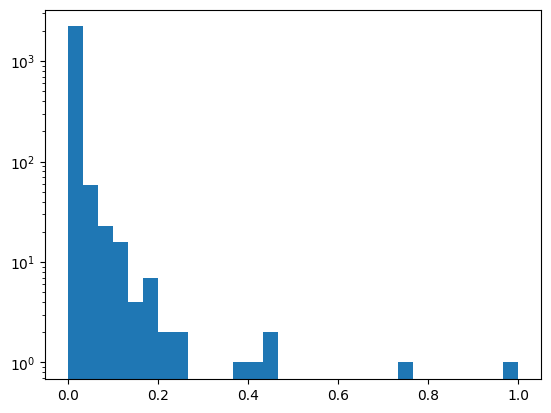

In [32]:
column_to_look = 49
plt.hist(normalized_matrix[:, column_to_look], bins=30)
plt.yscale('log')

2335


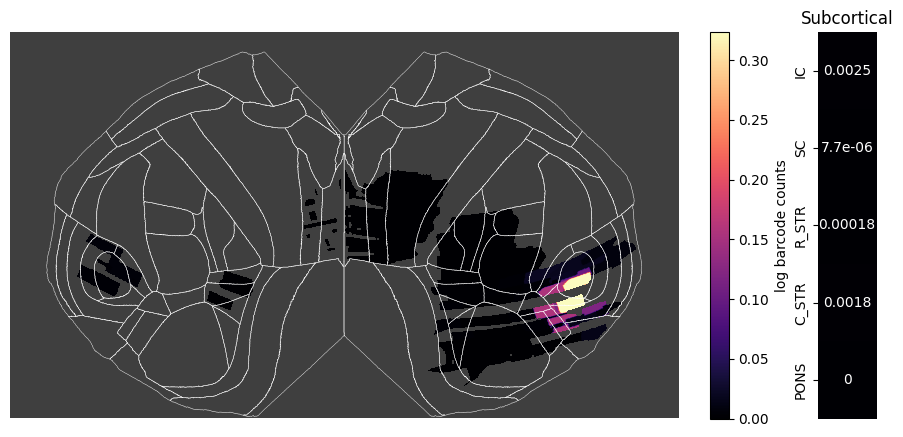

In [43]:

# require a threshold for col of interest projection strength

column_x = 29 # Column to filter on
threshold = 0

# Normalize each row to its maximum value
normalized_matrix = barcode_matrix / np.max(barcode_matrix, axis=1, keepdims=True)

# Filter rows based on values greater than 0 in column_x
filtered_matrix = normalized_matrix[normalized_matrix[:, column_x] >= threshold]
print(len(filtered_matrix))

normalized_matrix_mean = np.mean(filtered_matrix, axis=0)
normalized_matrix_mean[0] = -1
fig = plt.figure(figsize=(12, 300))
cmap = plt.cm.get_cmap("magma").copy()
#new_colours = cmap(np.linspace(0, 1, 30))
#grey = ([0.3, 0.3, 0.3, 1])
#new_colours[0, :] = grey
#new_cmap = ListedColormap(new_colours)
cmap.set_bad(color=[0.25, 0.25, 0.25, 1])       
gs = fig.add_gridspec(50, 2, width_ratios=[2, 0.15])

ax1 = fig.add_subplot(gs[1, 0])

new_mat = np.log(1 + normalized_matrix_mean[ROI_projection_max.astype(int)]).T
new_fig = ax1.imshow(new_mat, cmap=cmap)
ax1.axis('off')
cbar = fig.colorbar(new_fig, ax=ax1, fraction=0.03, pad=0.04)
cbar.set_label('log barcode counts')


for k, boundary_coords in bf_left_boundaries.items():
    ax1.plot(*boundary_coords.T, c="white", lw=0.3)
for k, boundary_coords in bf_right_boundaries.items():
    ax1.plot(*boundary_coords.T, c="white", lw=0.3)

# Subplot - Seaborn heatmap
sub_cort_heat = pd.DataFrame(columns=sub_cortical.keys(), dtype="float")
for col in sub_cort_heat.columns:
        sub_cort_heat.loc[0, col] = np.log(normalized_matrix_mean[sub_cortical_updated[col]].sum()+1)
ax2 = fig.add_subplot(gs[1, 1])
sb.heatmap(sub_cort_heat.T, annot=True, cmap=cmap, cbar=False, cbar_ax=ax2, vmax=new_mat.max())
ax2.set_title('Subcortical')
ax2.set(xticklabels=[])
#ax2.set_yticklabels(labels=sub_cortical.keys(), rotation=0)
ax2.tick_params(left=True, bottom=False)

Get average projectino patterns with different source sites

In [95]:
source = [36]
source_filtered_barcodes_spike_normalised = normalised_barcode_path[normalised_barcode_path.idxmax(axis=1).isin(source)]

In [96]:
source_filtered_barcodes_spike_normalised

,1,2,3,4,6,7,8,9,10,11,...,93,80,81,82,83,84,85,86,89,90
sequence,,,,,,,,,,,,,,,,,,,,,
CATGCTTTATCTTTATATTGTGCACATGACTC,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,4.030344,1.511072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AATTATTGTTGTGTTATCCAGCTCAACCCCCT,0.0,0.0,0.0,0.0,0.0,1.626345,0.0,0.0,4.030344,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CTGCTTGTTGCCGTATCACCCATGATCCGGTC,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCTCACCCTCGCTGAGAGCCGCACTGTTGGTC,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CTTCCCAAACACTCGTCTCCATTACTTCACCT,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CGTGAGGCATCCTACATTTACATTTTCCCTCC,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CGTATTGGTTGCGTTTTATCAACCGTGATCTC,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CGTATTTCGGCAACGCTTTTAAGCTCCCAATC,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
barcode_matrix = np.zeros((len(source_filtered_barcodes_spike_normalised), max(source_filtered_barcodes_spike_normalised.columns.to_list())+1))

for column in source_filtered_barcodes_spike_normalised:
    barcode_matrix[:, column] = source_filtered_barcodes_spike_normalised[column].to_numpy()

#now set zero values to -1
barcode_matrix[:, 0] = -1

In [98]:
areas_vis = areas.set_index('sample')
vis = areas_vis.filter(like="VIS").columns
areas_vis = areas_vis[vis]
areas_vis =areas_vis.drop(['VISC', 'Contra-VISa', 'Contra-VISam', 'Contra-VISC'], axis=1)
areas_vis =areas_vis.loc[~(areas_vis==0).all(axis=1)]
visual_areas =areas_vis.index.to_list()
#remove the samples that are not in final qc and turn to int
visual_areas_list = []
for val in visual_areas:
    if val in normalised_barcode_path.columns.to_list():
        visual_areas_list.append(int(val))
non_zero_rows = np.any(barcode_matrix[:, visual_areas_list] != 0, axis=1)
filtered_vis_only = barcode_matrix[non_zero_rows]


In [83]:
#take only those projection to visual areas


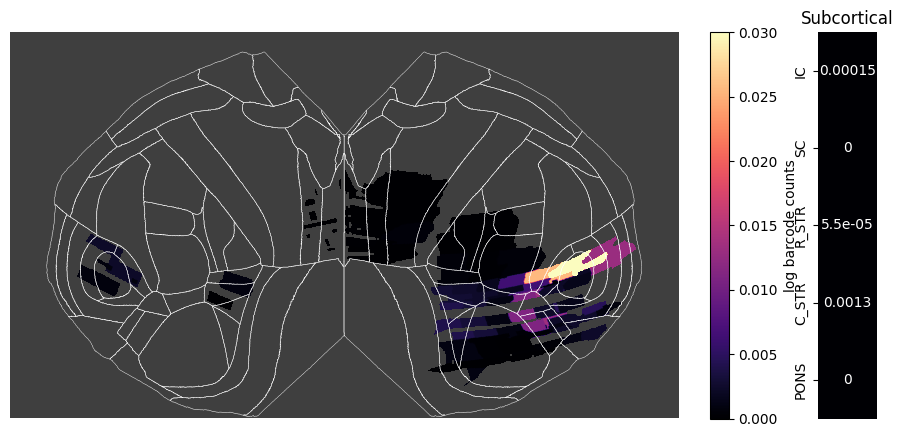

In [99]:
# Normalize each row to its maximum value
normalized_matrix = filtered_vis_only / np.max(filtered_vis_only, axis=1, keepdims=True)



normalized_matrix_mean = np.mean(normalized_matrix, axis=0)
normalized_matrix_mean[0] = -1
fig = plt.figure(figsize=(12, 300))
cmap = plt.cm.get_cmap("magma").copy()
#new_colours = cmap(np.linspace(0, 1, 30))
#grey = ([0.3, 0.3, 0.3, 1])
#new_colours[0, :] = grey
#new_cmap = ListedColormap(new_colours)
cmap.set_bad(color=[0.25, 0.25, 0.25, 1])       
gs = fig.add_gridspec(50, 2, width_ratios=[2, 0.15])

ax1 = fig.add_subplot(gs[1, 0])

new_mat = np.log(1 + normalized_matrix_mean[ROI_projection_max.astype(int)]).T
new_fig = ax1.imshow(new_mat, cmap=cmap, vmax= 0.03)
ax1.axis('off')
cbar = fig.colorbar(new_fig, ax=ax1, fraction=0.03, pad=0.04)
cbar.set_label('log barcode counts')


for k, boundary_coords in bf_left_boundaries.items():
    ax1.plot(*boundary_coords.T, c="white", lw=0.3)
for k, boundary_coords in bf_right_boundaries.items():
    ax1.plot(*boundary_coords.T, c="white", lw=0.3)

# Subplot - Seaborn heatmap
sub_cort_heat = pd.DataFrame(columns=sub_cortical.keys(), dtype="float")
for col in sub_cort_heat.columns:
        sub_cort_heat.loc[0, col] = np.log(normalized_matrix_mean[sub_cortical_updated[col]].sum()+1)
ax2 = fig.add_subplot(gs[1, 1])
sb.heatmap(sub_cort_heat.T, annot=True, cmap=cmap, cbar=False, cbar_ax=ax2, vmax=new_mat.max())
ax2.set_title('Subcortical')
ax2.set(xticklabels=[])
#ax2.set_yticklabels(labels=sub_cortical.keys(), rotation=0)
ax2.tick_params(left=True, bottom=False)